In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from einops.layers.torch import Rearrange

from timm.data.transforms_factory import create_transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from eyes.models.resnet import resnet18, resnet34
from eyes.trainer import train, test

from PIL import Image

%matplotlib inline

## Dealing with data

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
rand_gen = torch.manual_seed(0)
labeled_datafolder = "/home/dima/datasets/eyes/labeled/"
datafolder = "/home/dima/datasets/eyes/train/"
mrl_datafolder = "/home/dima/datasets/eyes/mrl/"
checkpoint_path = "/home/dima/eyes/checkpoints/"

In [3]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    create_transform(24, is_training=True, auto_augment='rand-m8-n3', mean=(0.5,), std=(0.5,),),
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    create_transform(24, is_training=False, mean=(0.5,), std=(0.5,),),
])

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Let's look at the MRL data

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


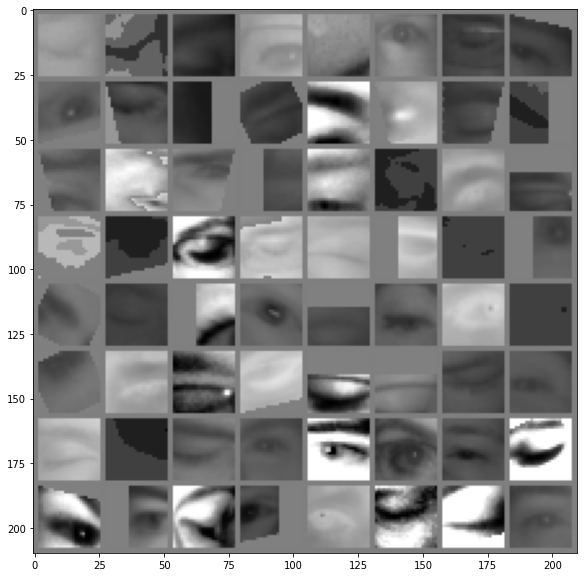

In [5]:
batch_size = 64
mrl_dataset = ImageFolder(mrl_datafolder, transform=train_transform)
train_size = int(len(mrl_dataset) * 0.9)
train_mrl_dataset, test_mrl_dataset = random_split(mrl_dataset, [train_size, len(mrl_dataset) - train_size])
trainloader = DataLoader(train_mrl_dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

## Training

In [6]:
batch_size = 512
mrl_dataset = ImageFolder(mrl_datafolder, transform=train_transform)
train_size = int(len(mrl_dataset) * 0.9)
train_mrl_dataset, test_mrl_dataset = random_split(mrl_dataset, [train_size, len(mrl_dataset) - train_size])
trainloader = DataLoader(train_mrl_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_mrl_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = resnet18().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
train(model, trainloader, optimizer, criterion, max_epochs=5)

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 0.784 acc: 0.559
[1,    20] loss: 0.624 acc: 0.648
[1,    30] loss: 0.585 acc: 0.687
[1,    40] loss: 0.555 acc: 0.701
[1,    50] loss: 0.547 acc: 0.716
[1,    60] loss: 0.524 acc: 0.728
[1,    70] loss: 0.502 acc: 0.747
[1,    80] loss: 0.497 acc: 0.739
[1,    90] loss: 0.477 acc: 0.748
[1,   100] loss: 0.473 acc: 0.761
[1,   110] loss: 0.461 acc: 0.763
[2,    10] loss: 0.456 acc: 0.770
[2,    20] loss: 0.437 acc: 0.775
[2,    30] loss: 0.413 acc: 0.792
[2,    40] loss: 0.423 acc: 0.792
[2,    50] loss: 0.409 acc: 0.801
[2,    60] loss: 0.405 acc: 0.801
[2,    70] loss: 0.398 acc: 0.805
[2,    80] loss: 0.419 acc: 0.795
[2,    90] loss: 0.396 acc: 0.810
[2,   100] loss: 0.377 acc: 0.812
[2,   110] loss: 0.374 acc: 0.817
[3,    10] loss: 0.366 acc: 0.823
[3,    20] loss: 0.362 acc: 0.822
[3,    30] loss: 0.374 acc: 0.823
[3,    40] loss: 0.369 acc: 0.823
[3,    50] loss: 0.358 acc: 0.829
[3,    60] loss: 0.369 acc: 0.819
[3,    70] loss: 0.359 acc: 0.836
[3,    80] los

Test on validation set from MRL

In [9]:
test(model, testloader, criterion)

Loss: 0.327 Acc: 0.853


Test on labeled part of original dataset

In [12]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_dataloader = DataLoader(labeled_dataset, batch_size=100, shuffle=False)
test(model, labeled_dataloader, criterion)

Loss: 0.210 Acc: 0.932


In [13]:
torch.save(model.state_dict(), os.path.join(checkpoint_path, "resnet18_93.pt"))

## Fine-tuning

In [40]:
model = resnet18().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_path, "resnet18_93.pt")))
for param in list(model.parameters())[:-14]:
    param.requires_grad = False

In [41]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_train, labeled_test = random_split(labeled_dataset, [800, 200])
labeled_trainloader = DataLoader(labeled_train, batch_size=100, shuffle=True)
labeled_testloader = DataLoader(labeled_test, batch_size=100, shuffle=False)

optimizer = optim.AdamW(list(model.parameters()), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [42]:
train(model, labeled_trainloader, optimizer, criterion, max_epochs=6, print_every_k_step=8)

[1,     8] loss: 0.254 acc: 0.914
[2,     8] loss: 0.198 acc: 0.927
[3,     8] loss: 0.138 acc: 0.954
[4,     8] loss: 0.120 acc: 0.955
[5,     8] loss: 0.082 acc: 0.974
[6,     8] loss: 0.051 acc: 0.985
Finished Training


In [43]:
test(model, labeled_testloader, criterion)

Loss: 0.193 Acc: 0.940


## Final model

In [44]:
model = resnet18().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_path, "resnet18_93.pt")))
for param in list(model.parameters())[:-14]:
    param.requires_grad = False

Fine-tune on the full dataset

In [45]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=100, shuffle=True)

optimizer = optim.AdamW(list(model.parameters()), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [46]:
train(model, labeled_loader, optimizer, criterion, max_epochs=6, print_every_k_step=10)

[1,    10] loss: 0.233 acc: 0.908
[2,    10] loss: 0.167 acc: 0.938
[3,    10] loss: 0.149 acc: 0.943
[4,    10] loss: 0.117 acc: 0.957
[5,    10] loss: 0.094 acc: 0.965
[6,    10] loss: 0.060 acc: 0.978
Finished Training


In [47]:
torch.save(model.state_dict(), os.path.join(checkpoint_path, "final.pt"))